# Test Classification Models for Predicting Recession with Real and Synthetic Data

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model

In [20]:
# set last date for training data (this time period has 4 recessions)
last_train_date = '12-31-1984'
last_test_date = '06-30-2009'

# number of steps in each sample (should equal synthetic_features.shape[1])
n_steps = 30

# specify # of days into future to look for recession
n_future = 250

# set threshold for predicting recession
thresh = 0.25

Synthetic Features should have two columns: 1-year Treasury Yield and 10-year Treasury Yield

Synthetic Attributes should have two columns: Recession indicator and future recession indicator

See DGAN_generation_classifier for details

In [21]:
# read in data from DGAN_generation_classifier
df = pd.read_csv("https://raw.githubusercontent.com/sdannels/synthetic_time_series_forecasting/main/Data/fred_data_classifier", 
                  index_col = 0, parse_dates = True)
synthetic_attributes = np.loadtxt("https://raw.githubusercontent.com/sdannels/synthetic_time_series_forecasting/main/Data/synthetic_attributes_classifier")
print(synthetic_attributes.shape)
synthetic_features = np.loadtxt("https://raw.githubusercontent.com/sdannels/synthetic_time_series_forecasting/main/Data/synthetic_features_reshaped_classifier")
synthetic_features = synthetic_features.reshape(50000, 30, 2)
print(synthetic_features.shape)

(50000, 2)
(50000, 30, 2)


In [22]:
# create variable that indicates if there is a recession in the next n_future days
df_counter = df.copy().reset_index()
rec_future = list()
for i in range(len(df)):
  subset = df_counter.loc[i:i+n_future, 'USRECD']
  rec_max = subset.max()
  rec_future.append(rec_max)
del df_counter
df['rec_future'] = rec_future
# filter out current recessions from future_recess_indic
df.loc[df['USRECD'] == 1, 'rec_future'] = 0

# split up training and testing data
train_df = df[df.index <= last_train_date]
test_df = df[(df.index > last_train_date) & (df.index <= last_test_date)]

In [23]:
# function to reformat data from df to numpy array
def df_to_np(df, cols):
  """
    df: pandas DataFrame
    cols = list of column names from df to include
  """
  data = df[cols]
  data = data.to_numpy()
  return data

# function to split data into samples for training
def split_classifier_samples(data, n_steps, feature_cols, response_cols):
  """
  data: numpy array with all data
  n_steps: # of steps in each sample
  feature_cols: column index where features occur
                (e.g., if first two columns are features, features_cols = range(2))
  response_cols: column(s) index where response is
  """
  X, y = list(), list()
  for i in range(len(data)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(data)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = data[i:end_ix, feature_cols], data[end_ix, response_cols]
    max_y = seq_y.max()
    X.append(seq_x)
    y.append(max_y)
  return np.array(X), np.array(y)

**Format data for training:**

The features are split into samples made up of a rolling window of size n_steps.
For example, if n_steps = 30, then the first sample will be the values of the features in the first 30 days of the data. The next sample will be the 2nd through 31st day, and so on.

The response is an indicator for whether or not a "future_recession" indicator is 1 in that sample. In other words, 1 indicates that a recession will occur sometime between n_future and n_future+n_steps days from the start of that sample.

In [24]:
# create training data
train_data = df_to_np(train_df, cols = ['DGS1', 'DGS10','rec_future'])

# split data for training
train_x, train_y = split_classifier_samples(train_data, n_steps = synthetic_features.shape[1],
                                            feature_cols = range(2), response_cols = 2)
train_y = train_y.astype(int)

# create test data
test_data = df_to_np(test_df, cols = ['DGS1', 'DGS10','rec_future'])

# split data for training
test_x, test_y = split_classifier_samples(test_data, n_steps = synthetic_features.shape[1],
                                          feature_cols = range(2), response_cols = 2)
test_y = test_y.astype(int)

In [25]:
# function to collect classification performance metrics
def evaluate_prob_preds(pred_probs, test_y = test_y):
  fpr, tpr, _ = roc_curve(test_y, pred_probs)
  auc = round(roc_auc_score(test_y, pred_probs), 4)
  return(fpr, tpr, auc)

# Logisitic Regression

## Real Data

In [26]:
# function to reshape feature data for logistic regression
# each row is a sample
# each column is a variable (n_steps*n_features)
def logit_x_reshape(x_data):
  for j in range(x_data.shape[0]):
    if j == 0:
      x_reshape = x_data[j].flatten('F')
    elif j == 1:
      x_reshape = np.stack([x_reshape, x_data[j].flatten('F')])
    else:
      x_reshape = np.concatenate([x_reshape, x_data[j].flatten('F').reshape(1, -1)], axis = 0)

  return(x_reshape)

In [27]:
# reshape training data for logisitic regression
train_x_logit = logit_x_reshape(train_x)
print(train_x_logit.shape)
# reshape test data for logisitic regression
test_x_logit = logit_x_reshape(test_x)
print(test_x_logit.shape)

(5701, 60)
(6096, 60)


In [28]:
# function to plot recession probability and recession times
def plot_recession_prob(prob_vector, title):
  #filter out recession dates
  recessions = test_df.index[test_df['USRECD'] == 1]

  plt.figure(figsize=(18, 8), dpi=80)
  # plot data
  plt.plot(test_df.index[n_steps:], prob_vector, 
           label = 'Prob. of Recession', color = 'red')
  #plot recession bars
  for day in recessions:
      plt.axvspan(day, day + dt.timedelta(days=1), color="lightgrey", alpha=0.25)
  plt.legend()
  plt.ylim(0,1)
  plt.title(title)
  plt.show()

In [29]:
# fit logistic regression model
logit_model = LogisticRegression(solver='saga', random_state=0, 
                                 penalty = 'l1')
logit_model.fit(train_x_logit, train_y)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(penalty='l1', random_state=0, solver='saga')

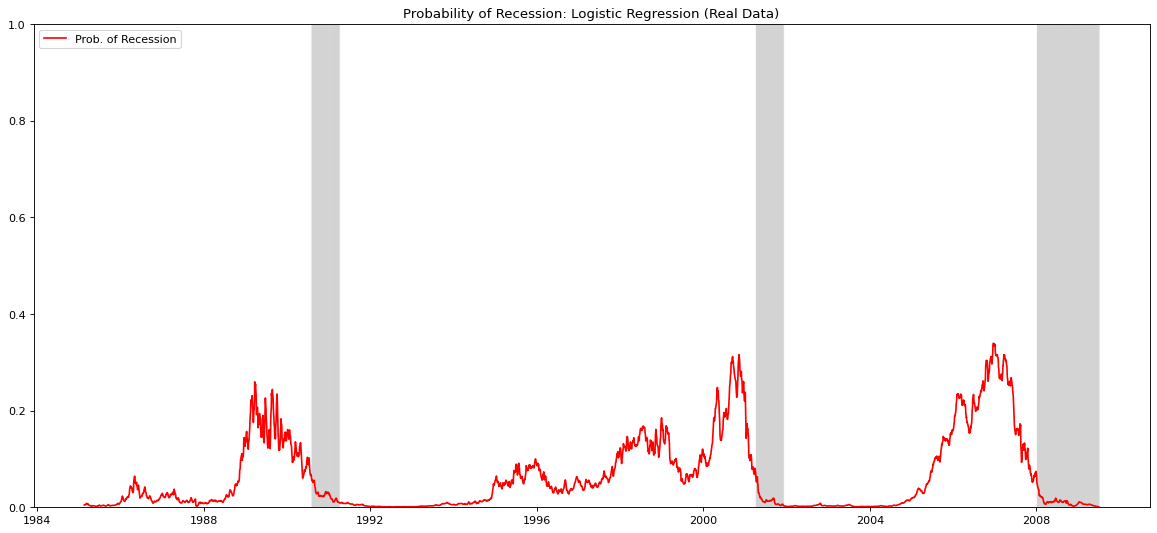

In [30]:
# predict on test data
logit_prob_recession = pd.Series(logit_model.predict_proba(test_x_logit)[:, 1])
logit_preds = (logit_model.predict_proba(test_x_logit)[:, 1] >= thresh)

# plot results
plot_recession_prob(logit_prob_recession, 'Probability of Recession: Logistic Regression (Real Data)')

In [31]:
# evaluate data
logit_fpr, logit_tpr, logit_auc = evaluate_prob_preds(logit_prob_recession)

## Synthetic Data

In [32]:
# use future_recess_indic from synthetic attributes as response
train_synth_y = synthetic_attributes[:, 1]
print(train_synth_y.shape)

(50000,)


In [33]:
# reshape synthetic feature training data for logisitic regression
train_synth_x_logit = logit_x_reshape(synthetic_features)
print(train_synth_x_logit.shape)

(50000, 60)


In [34]:
# fit logistic regression model
logit_synth_model = LogisticRegression(solver='saga', random_state=0, 
                                       penalty = 'l1', max_iter = 1e4)
logit_synth_model.fit(train_synth_x_logit, train_synth_y)

LogisticRegression(max_iter=10000.0, penalty='l1', random_state=0,
                   solver='saga')

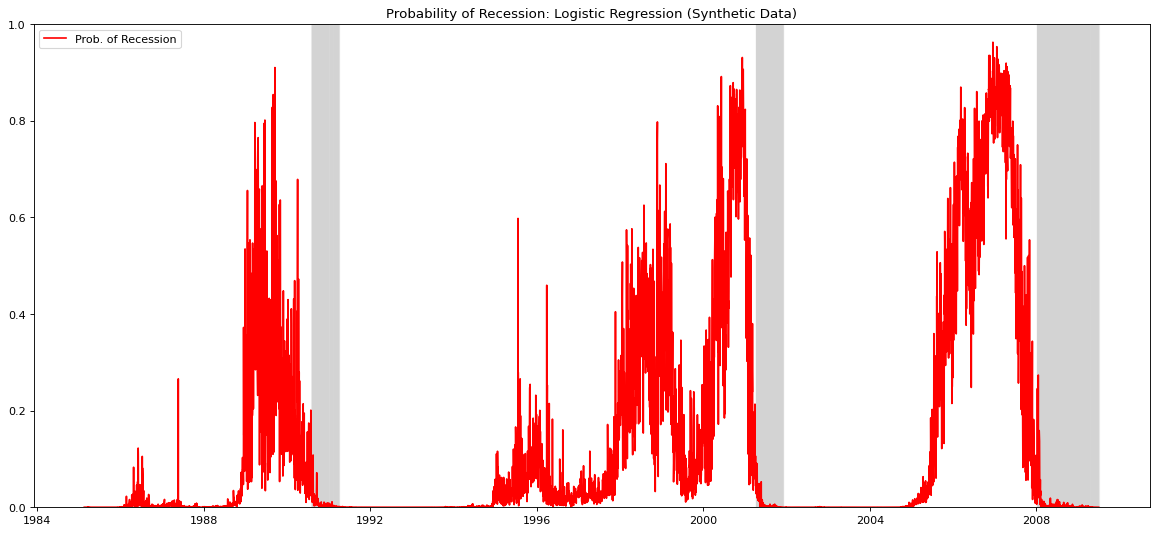

In [35]:
# predict on test data
logit_synth_prob_recession = pd.Series(logit_synth_model.predict_proba(test_x_logit)[:, 1])
logit_synth_preds = (logit_synth_model.predict_proba(test_x_logit)[:, 1] >= thresh)

# plot results
plot_recession_prob(logit_synth_prob_recession, 'Probability of Recession: Logistic Regression (Synthetic Data)')

In [ ]:
# evaluate data
logit_synth_fpr, logit_synth_tpr, logit_synth_auc = evaluate_prob_preds(logit_synth_prob_recession)

## Combined Data

In [ ]:
# combine features for training
train_x_logit_combined = np.concatenate([train_x_logit, train_synth_x_logit], axis = 0)
print(train_x_logit_combined.shape)
train_y_logit_combined = np.concatenate([train_y, train_synth_y], axis = 0)
print(train_y_logit_combined.shape)

(55701, 60)
(55701,)


In [ ]:
# fit logistic regression model
logit_comb_model = LogisticRegression(solver='saga', random_state=0, 
                                       penalty = 'l1', max_iter = 1e4)
logit_comb_model.fit(train_x_logit_combined, train_y_logit_combined)

LogisticRegression(max_iter=10000.0, penalty='l1', random_state=0,
                   solver='saga')

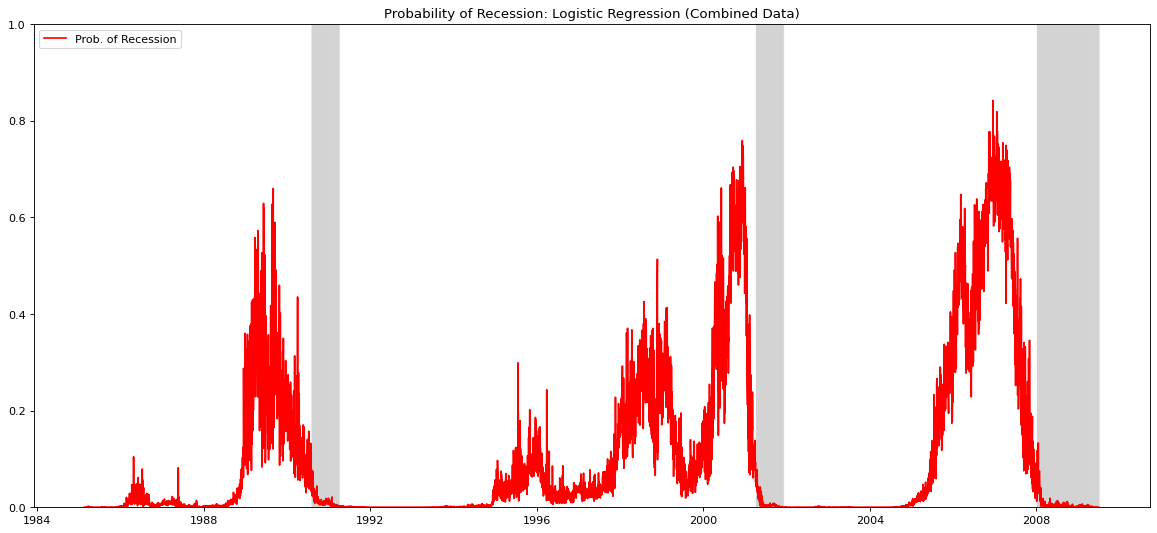

In [ ]:
# predict on test data
logit_comb_prob_recession = pd.Series(logit_comb_model.predict_proba(test_x_logit)[:, 1])
logit_comb_preds = (logit_comb_model.predict_proba(test_x_logit)[:, 1] >= thresh)

# plot results
plot_recession_prob(logit_comb_prob_recession, 'Probability of Recession: Logistic Regression (Combined Data)')

In [ ]:
# evaluate data
logit_comb_fpr, logit_comb_tpr, logit_comb_auc = evaluate_prob_preds(logit_comb_prob_recession)

## Evaluation

In [ ]:
# set compare colors
compare_colors = ['tomato', 'cadetblue', 'mediumpurple']

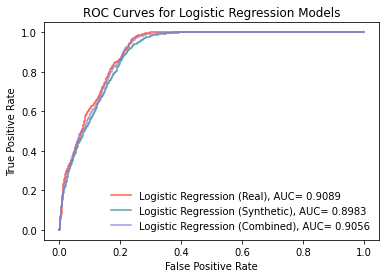

In [ ]:
plt.plot(logit_fpr,logit_tpr,
         label=f"Logistic Regression (Real), AUC= {logit_auc}", color = compare_colors[0])
plt.plot(logit_synth_fpr,logit_synth_tpr,
         label=f"Logistic Regression (Synthetic), AUC= {logit_synth_auc}", color = compare_colors[1], alpha = 1)
plt.plot(logit_comb_fpr,logit_comb_tpr,
         label=f"Logistic Regression (Combined), AUC= {logit_comb_auc}", color = compare_colors[2], alpha = 0.75)
plt.legend(frameon = False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression Models')
#plt.savefig('/content/drive/MyDrive/Figures/logit_roc.eps', format = 'eps')
plt.show()

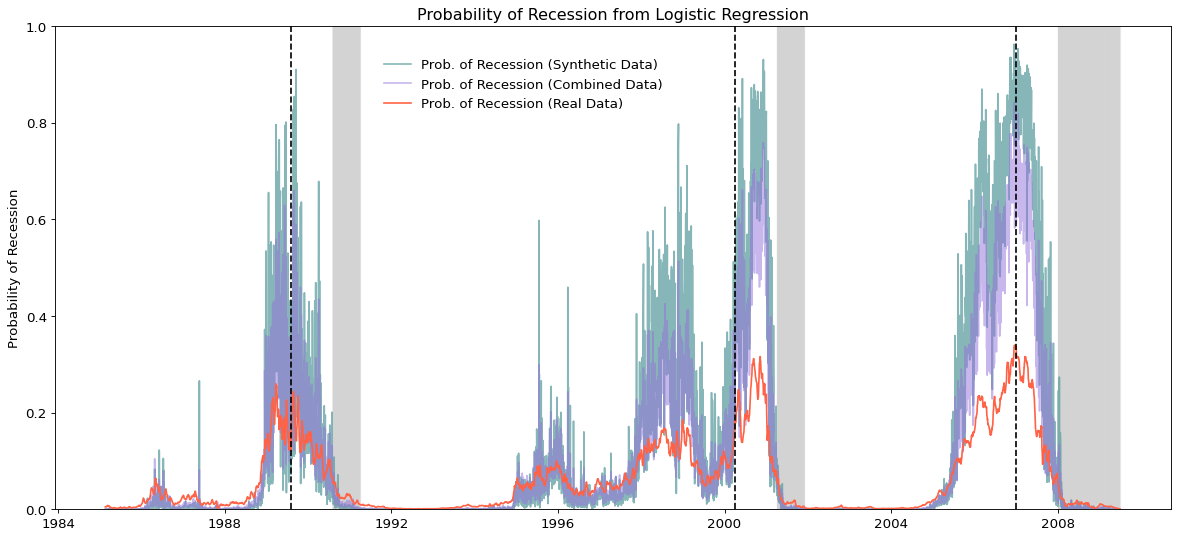

In [ ]:
# set font
plt.rcParams.update({'font.size': 12})

#filter out recession dates
recessions = test_df.index[test_df['USRECD'] == 1]

# set dates for 250 mark
recession_future_marker = ['1989-08-02', '2000-04-03', '2007-01-03']

plt.figure(figsize=(18, 8), dpi=80)
# plot data
plt.plot(test_df.index[n_steps:], logit_synth_prob_recession, 
         label = 'Prob. of Recession (Synthetic Data)', color = compare_colors[1], alpha = 0.75)
plt.plot(test_df.index[n_steps:], logit_comb_prob_recession, 
         label = 'Prob. of Recession (Combined Data)', color = compare_colors[2],  alpha = 0.5)
plt.plot(test_df.index[n_steps:], logit_prob_recession, 
         label = 'Prob. of Recession (Real Data)', color = compare_colors[0])
#plot recession bars
for day in recessions:
  plt.axvspan(day, day + dt.timedelta(days=1), color="lightgrey", alpha=0.25)
# plot 250 mark lines
for rm in recession_future_marker:
  plt.axvline(dt.datetime.strptime(rm, '%Y-%m-%d'), 
              label = '', color = 'black', linestyle = 'dashed')

plt.legend(bbox_to_anchor = (0.42, 0.8), frameon = False)
plt.ylim(0,1)
plt.title('Probability of Recession from Logistic Regression')
plt.ylabel('Probability of Recession')
#plt.savefig('/content/drive/MyDrive/Figures/logit_prob_recession.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

# LSTM Classifier

## Real Data

In [11]:
# set batch size for LSTM model
batch_size = 30

# initialize one-hot encoder
encoder = OneHotEncoder(handle_unknown='ignore')
# one hot encode target variable for LSTM model
train_y_encoded = encoder.fit_transform(train_y.reshape(-1, 1)).toarray()

In [12]:
# configure classifier model
LSTM_model = Sequential()
LSTM_model.add(LSTM(30, activation='tanh', input_shape=(train_x.shape[1], train_x.shape[2])))
LSTM_model.add(Dropout(0.5))
LSTM_model.add(Dense(100, activation = 'tanh'))
LSTM_model.add(Dense(2, activation = 'softmax'))
LSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

**Option to load previously trained model or train new model**

In [13]:
# if true, load a pretrained model instead of training
load_pretrain = True

if load_pretrain == True:
  LSTM_model = load_model("/content/drive/MyDrive/Models/LSTM_classifier_model")
else:
  # fit model
  LSTM_model.fit(train_x, train_y_encoded,
                 epochs = 50, batch_size = batch_size, verbose = 2)

In [14]:
# save model after training
#LSTM_model.save("/content/drive/MyDrive/Models/LSTM_classifier_model")

191/191 [==============================] - 3s 9ms/step


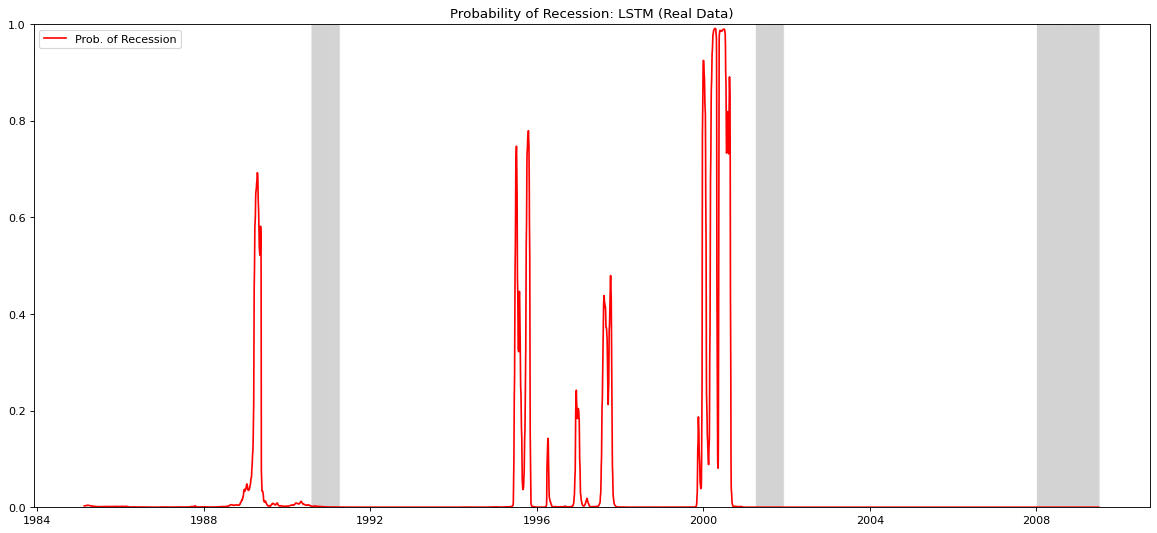

In [15]:
# predict on test data
LSTM_prob_recession = pd.Series(LSTM_model.predict(test_x)[:,1])

# plot results
plot_recession_prob(LSTM_prob_recession, 'Probability of Recession: LSTM (Real Data)')

In [16]:
# evaluate data
LSTM_fpr, LSTM_tpr, LSTM_auc = evaluate_prob_preds(LSTM_prob_recession)

## Synthetic Data

In [18]:
# one hot encode target variable for LSTM model
train_synth_y_encoded = encoder.fit_transform(train_synth_y.reshape(-1, 1)).toarray()

In [ ]:
# configure classifier model
LSTM_synth_model = Sequential()
LSTM_synth_model.add(LSTM(30, activation='tanh', input_shape=(synthetic_features.shape[1], synthetic_features.shape[2])))
LSTM_synth_model.add(Dropout(0.5))
LSTM_synth_model.add(Dense(100, activation = 'tanh'))
LSTM_synth_model.add(Dense(2, activation = 'softmax'))
LSTM_synth_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# if true, load a pretrained model instead of training
load_synth_pretrain = True

if load_synth_pretrain == True:
  LSTM_synth_model = load_model("/content/drive/MyDrive/Models/LSTM_synth_classifier_model")
else:
  # fit model
  LSTM_synth_model.fit(synthetic_features, train_synth_y_encoded,
                       epochs = 50, batch_size = batch_size, verbose = 2)

In [ ]:
# save model after training
#LSTM_synth_model.save("/content/drive/MyDrive/Models/LSTM_synth_classifier_model")

191/191 [==============================] - 2s 10ms/step


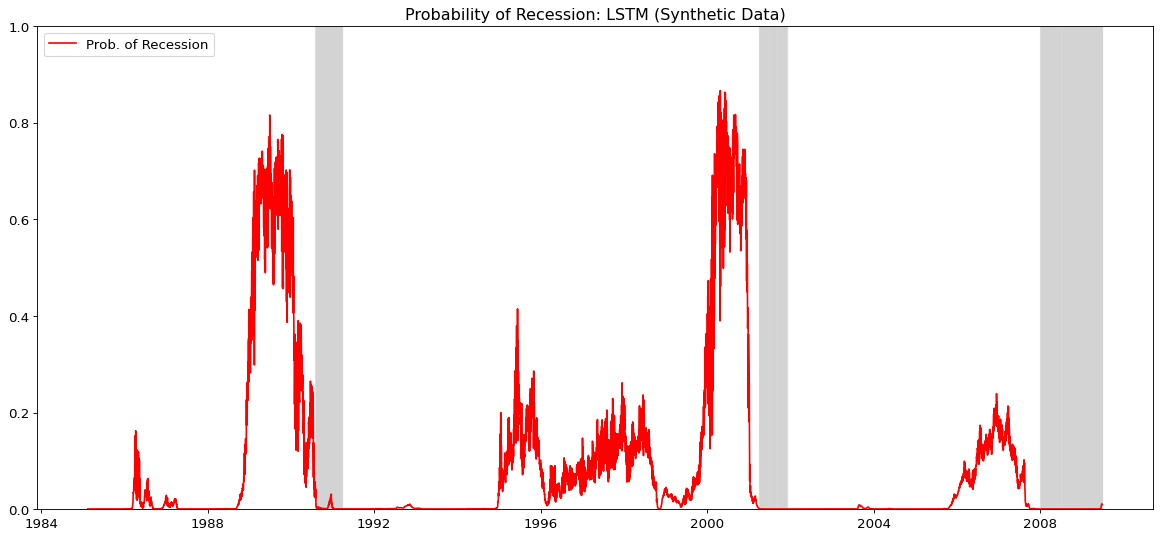

In [ ]:
# predict on test data
LSTM_synth_prob_recession = pd.Series(LSTM_synth_model.predict(test_x)[:,1])

# plot results
plot_recession_prob(LSTM_synth_prob_recession, 'Probability of Recession: LSTM (Synthetic Data)')

In [ ]:
# evaluate data
LSTM_synth_fpr, LSTM_synth_tpr, LSTM_synth_auc = evaluate_prob_preds(LSTM_synth_prob_recession)

## Combined Data

In [ ]:
# combine features for training
train_x_combined = np.concatenate([train_x, synthetic_features], axis = 0)
print(train_x_combined.shape)
train_y_combined = np.concatenate([train_y_encoded, train_synth_y_encoded], axis = 0)
print(train_y_combined.shape)

(55701, 30, 2)
(55701, 2)


In [ ]:
# configure classifier model
LSTM_comb_model = Sequential()
LSTM_comb_model.add(LSTM(30, activation='tanh', input_shape=(train_x_combined.shape[1], train_x_combined.shape[2])))
LSTM_comb_model.add(Dropout(0.5))
LSTM_comb_model.add(Dense(100, activation = 'tanh'))
LSTM_comb_model.add(Dense(2, activation = 'softmax'))
LSTM_comb_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# if true, load a pretrained model instead of training
load_comb_pretrain = True

if load_comb_pretrain == True:
  LSTM_comb_model = load_model("/content/drive/MyDrive/Models/LSTM_comb_classifier_model")
else:
  # fit model
  LSTM_comb_model.fit(train_x_combined, train_y_combined,
                      epochs = 50, batch_size = batch_size, verbose = 2)

In [ ]:
# save model after training
#LSTM_comb_model.save("/content/drive/MyDrive/Models/LSTM_comb_classifier_model")

191/191 [==============================] - 1s 5ms/step


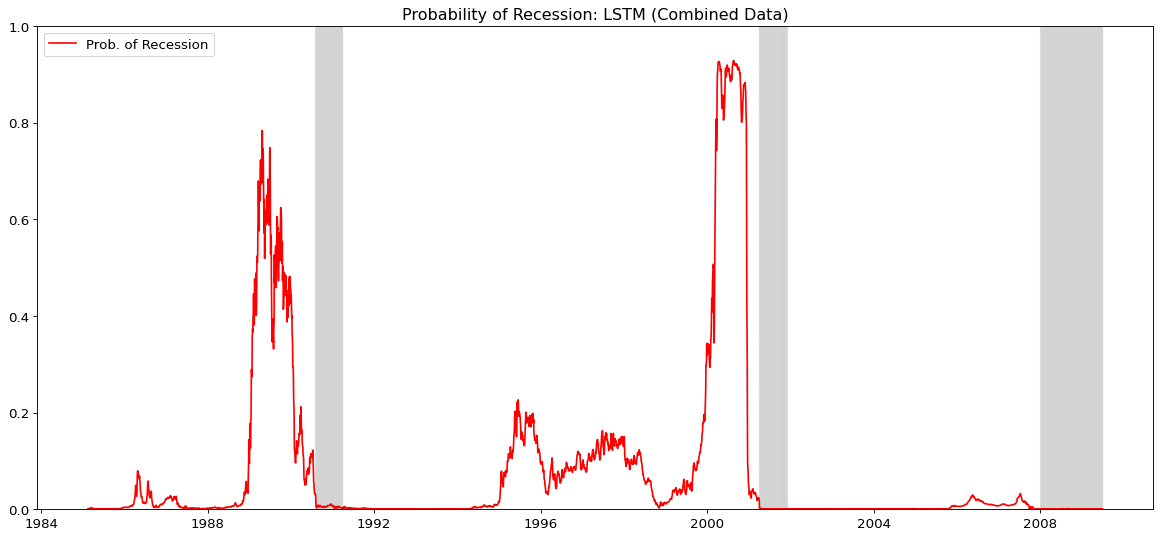

In [ ]:
# predict on test data
LSTM_comb_prob_recession = pd.Series(LSTM_comb_model.predict(test_x)[:,1])

# plot results
plot_recession_prob(LSTM_comb_prob_recession, 'Probability of Recession: LSTM (Combined Data)')

In [ ]:
# evaluate data
LSTM_comb_fpr, LSTM_comb_tpr, LSTM_comb_auc = evaluate_prob_preds(LSTM_comb_prob_recession)

## Evaluation

<bound method Figure.show of <Figure size 1080x360 with 2 Axes>>

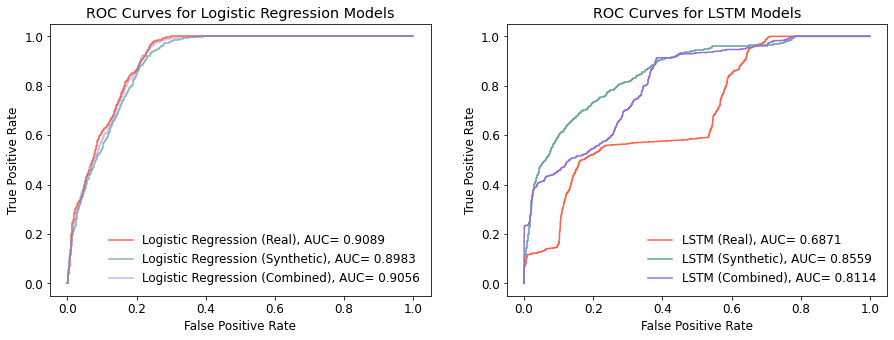

In [ ]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

# plot ROC curves
ax1.plot(logit_fpr,logit_tpr,
         label=f"Logistic Regression (Real), AUC= {logit_auc}", color = compare_colors[0])
ax1.plot(logit_synth_fpr,logit_synth_tpr,
         label=f"Logistic Regression (Synthetic), AUC= {logit_synth_auc}", color = compare_colors[1], alpha = 0.75)
ax1.plot(logit_comb_fpr,logit_comb_tpr,
         label=f"Logistic Regression (Combined), AUC= {logit_comb_auc}", color = compare_colors[2], alpha = 0.5)
ax1.legend(frameon = False)
ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate',
        title = 'ROC Curves for Logistic Regression Models')

ax2.plot(LSTM_fpr,LSTM_tpr,
         label=f"LSTM (Real), AUC= {LSTM_auc}", color = compare_colors[0])
ax2.plot(LSTM_synth_fpr,LSTM_synth_tpr,
         label=f"LSTM (Synthetic), AUC= {LSTM_synth_auc}", color = compare_colors[1])
ax2.plot(LSTM_comb_fpr,LSTM_comb_tpr,
         label=f"LSTM (Combined), AUC= {LSTM_comb_auc}", color = compare_colors[2])
ax2.legend(frameon = False)
ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate',
        title = 'ROC Curves for LSTM Models')
# save figure
#fig.savefig('/content/drive/MyDrive/Figures/recession_roc_curves.pdf', format = 'pdf', bbox_inches = 'tight')
fig.show

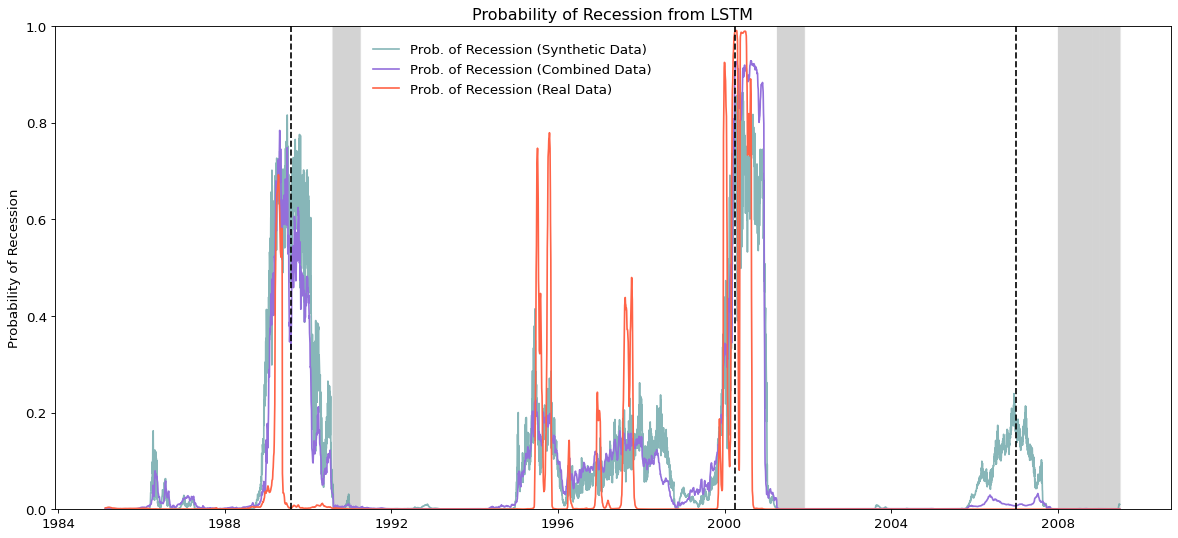

In [ ]:
#filter out recession dates
recessions = test_df.index[test_df['USRECD'] == 1]

# set dates for 250 mark
recession_future_marker = ['1989-08-02', '2000-04-03', '2007-01-03']

plt.figure(figsize=(18, 8), dpi=80)
# plot data
plt.plot(test_df.index[n_steps:], LSTM_synth_prob_recession, 
         label = 'Prob. of Recession (Synthetic Data)', color = compare_colors[1], alpha = 0.75)
plt.plot(test_df.index[n_steps:], LSTM_comb_prob_recession, 
         label = 'Prob. of Recession (Combined Data)', color = compare_colors[2],  alpha = 1)
plt.plot(test_df.index[n_steps:], LSTM_prob_recession, 
         label = 'Prob. of Recession (Real Data)', color = compare_colors[0])
#plot recession bars
for day in recessions:
  plt.axvspan(day, day + dt.timedelta(days=1), color="lightgrey", alpha=0.25)

# plot 250 mark lines
for rm in recession_future_marker:
  plt.axvline(dt.datetime.strptime(rm, '%Y-%m-%d'), 
              label = '', color = 'black', linestyle = 'dashed')
  
plt.legend(bbox_to_anchor = (0.41, 0.83), frameon = False)
plt.ylim(0,1)
plt.title('Probability of Recession from LSTM')
plt.ylabel('Probability of Recession')
#plt.savefig('/content/drive/MyDrive/Figures/LSTM_prob_of_recession.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()